In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

In [3]:
# Путь к директории с моделями
MODELS_PATH = Path("models/final_best")
print(f"📂 Директория моделей: {MODELS_PATH.absolute()}")

📂 Директория моделей: c:\Users\nurs\PycharmProjects\pythonProject5\.ipynb_checkpoints\models\final_best


In [4]:
# --- Загрузка Random Forest (Winner 🏆) ---
try:
    rf_model = joblib.load(MODELS_PATH / "random_forest_tuned.joblib")
    print("✅ Random Forest успешно загружен!")
    print(f"   Параметры: {rf_model.named_steps['model'].get_params()['n_estimators']} деревьев, "
          f"max_depth={rf_model.named_steps['model'].get_params()['max_depth']}")
except FileNotFoundError:
    print("❌ Файл модели не найден. Проверьте путь.")

✅ Random Forest успешно загружен!
   Параметры: 871 деревьев, max_depth=6


In [5]:
# --- Загрузка CatBoost (Runner-up 🥈) ---
try:
    cb_model = joblib.load(MODELS_PATH / "catboost_tuned.joblib")
    print("✅ CatBoost успешно загружен!")
    print(f"   Параметры: depth={cb_model.get_param('depth')}, "
          f"iterations={cb_model.get_param('iterations')}, "
          f"learning_rate={cb_model.get_param('learning_rate'):.4f}")
except FileNotFoundError:
    print("❌ Файл модели не найден.")

✅ CatBoost успешно загружен!
   Параметры: depth=4, iterations=712, learning_rate=0.0178


In [6]:
# --- Загрузка базовых моделей (Baselines) ---
models = {}

# Логистическая регрессия
try:
    lr_model = joblib.load(MODELS_PATH / "logistic_regression_tuned.joblib")
    models["Logistic Regression"] = lr_model
    print("✅ Logistic Regression загружена")
except:
    print("⚠️ Logistic Regression не найдена")

# Дерево решений
try:
    dt_model = joblib.load(MODELS_PATH / "decision_tree_tuned.joblib")
    models["Decision Tree"] = dt_model
    print("✅ Decision Tree загружено")
except:
    print("⚠️ Decision Tree не найдено")

✅ Logistic Regression загружена
✅ Decision Tree загружено


In [7]:
# --- Загрузка тестовой выборки ---
DATA_PATH = Path("data/processed")

try:
    # Загружаем данные, подготовленные для деревьев (так как победил RF)
    # Обратите внимание: путь должен совпадать с тем, куда вы сохраняли сплиты в 02_Preprocessing
    X_test_rf, y_test = joblib.load(DATA_PATH / "tree_data_split.joblib")[1::2] # Берем только X_test и y_test
    
    # Для CatBoost данные могут отличаться (если вы не использовали OHE), 
    # но часто можно использовать те же данные, если CatBoost умеет работать с ними.
    # Если вы сохраняли отдельно catboost_data.joblib:
    cb_data = joblib.load(DATA_PATH / "catboost_data.joblib")
    X_test_cb = cb_data["X_test"]
    
    print(f"✅ Тестовые данные загружены.")
    print(f"   Размер выборки: {X_test_rf.shape[0]} записей")
except FileNotFoundError:
    print("❌ Файлы данных не найдены. Убедитесь, что препроцессинг был выполнен.")

✅ Тестовые данные загружены.
   Размер выборки: 1407 записей


In [10]:
X_test_cb.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,avg_monthly_spend,num_services,is_month_to_month,has_internet,Partner,Dependents,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure_group
974,0,59,75.95,4542.35,75.705833,4,0,1,Yes,Yes,...,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),49+
619,0,7,78.55,522.95,65.368750,1,1,1,No,No,...,No,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),0-12
4289,0,54,20.10,1079.45,19.626364,0,0,0,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,49+
3721,0,2,20.65,38.70,12.900000,0,1,0,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0-12
4533,0,71,105.15,7555.00,104.930556,4,0,1,Yes,No,...,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),49+


In [11]:
numeric_features = [
    'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 
    'avg_monthly_spend', 'num_services', 'is_month_to_month', 'has_internet'
]

def get_feature_names(pipeline):
    """Извлекает имена признаков из Pipeline с ColumnTransformer"""
    try:
        # Достаем препроцессор
        preprocessor = pipeline.named_steps['preprocessor']
        
        # Получаем имена категориальных признаков после OneHotEncoder
        # (обычно это трансформер с именем 'cat')
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
        
        # Объединяем с числовыми (в том порядке, в котором они собирались в ColumnTransformer)
        # В вашем коде: transformers=[('num', ...), ('cat', ...)]
        # Значит порядок: Numeric -> Categorical
        # НО! Если вы использовали remainder='passthrough', порядок может быть другим.
        # В 04 файле для LogReg: transformers=[('num',...), ('cat',...)] -> Сначала Num, потом Cat
        # В 04 файле для Tree: remainder='passthrough', transformers=[('cat',...)] -> Сначала Cat, потом Num (remainder в конце)
        
        # Проверка типа препроцессора для определения порядка:
        if 'num' in preprocessor.named_transformers_:
             # Если явно задан 'num', скорее всего он идет первым (как в LR)
             return np.r_[numeric_features, cat_features]
        else:
             # Если 'num' нет (passthrough), то трансформеры идут первыми ('cat'), а passthrough ('num') в конце
             return np.r_[cat_features, numeric_features]
             
    except Exception as e:
        print(f"⚠️ Не удалось извлечь имена автоматически: {e}")
        return None

C:\Users\nurs\AppData\Local\Temp\ipykernel_2444\3630915639.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_rf, palette='viridis')


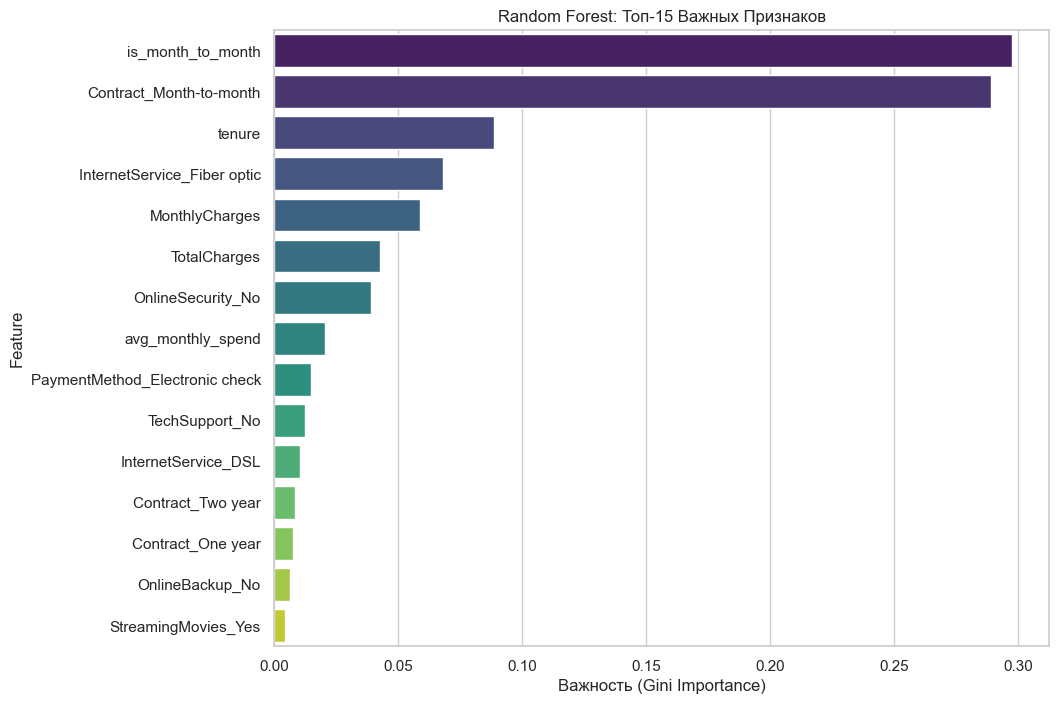

In [12]:
# --- Random Forest ---
# 1. Получаем модель и имена
rf_model_step = rf_model.named_steps['model']
feature_names_rf = get_feature_names(rf_model)

# 2. Создаем DataFrame
importances_rf = pd.DataFrame({
    'Feature': feature_names_rf,
    'Importance': rf_model_step.feature_importances_
})

# 3. Сортируем
importances_rf = importances_rf.sort_values(by='Importance', ascending=False).head(15)

# 4. Рисуем
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_rf, palette='viridis')
plt.title('Random Forest: Топ-15 Важных Признаков')
plt.xlabel('Важность (Gini Importance)')
plt.show()

C:\Users\nurs\AppData\Local\Temp\ipykernel_2444\3831462780.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_cb, palette='magma')


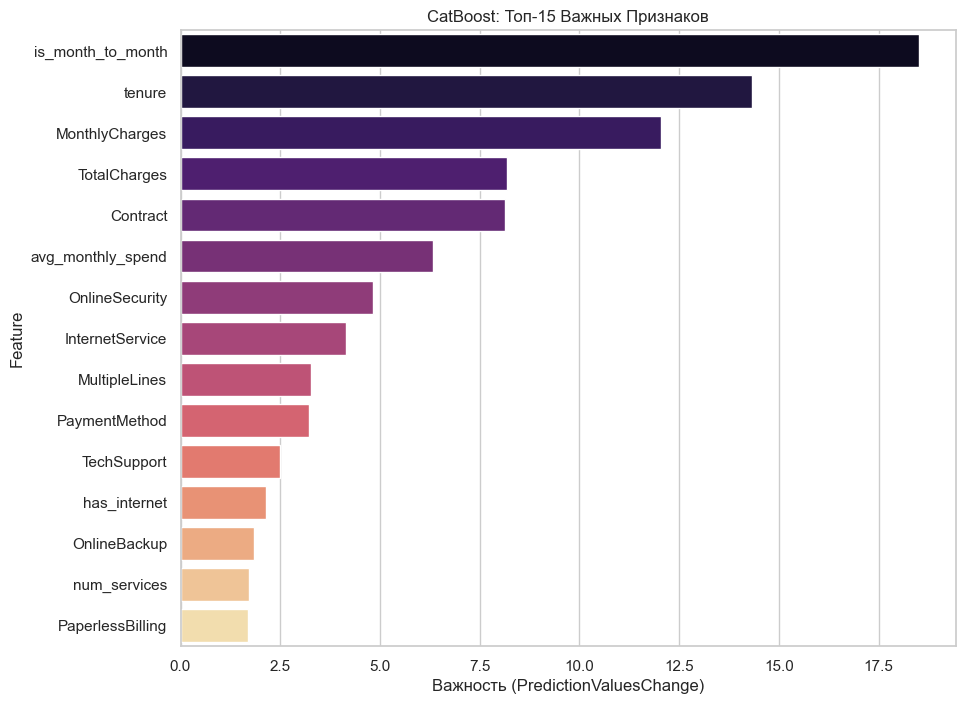

In [13]:
# --- CatBoost ---
# 1. Получаем важность (CatBoost помнит имена колонок сам, если обучался на DataFrame)
# Если cb_model - это объект CatBoostClassifier
imp_values = cb_model.get_feature_importance()
feat_names = cb_model.feature_names_

# 2. Создаем DataFrame
importances_cb = pd.DataFrame({
    'Feature': feat_names,
    'Importance': imp_values
})

# 3. Сортируем
importances_cb = importances_cb.sort_values(by='Importance', ascending=False).head(15)

# 4. Рисуем
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_cb, palette='magma')
plt.title('CatBoost: Топ-15 Важных Признаков')
plt.xlabel('Важность (PredictionValuesChange)')
plt.show()

C:\Users\nurs\AppData\Local\Temp\ipykernel_2444\1772705302.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=importances_lr, palette=colors)


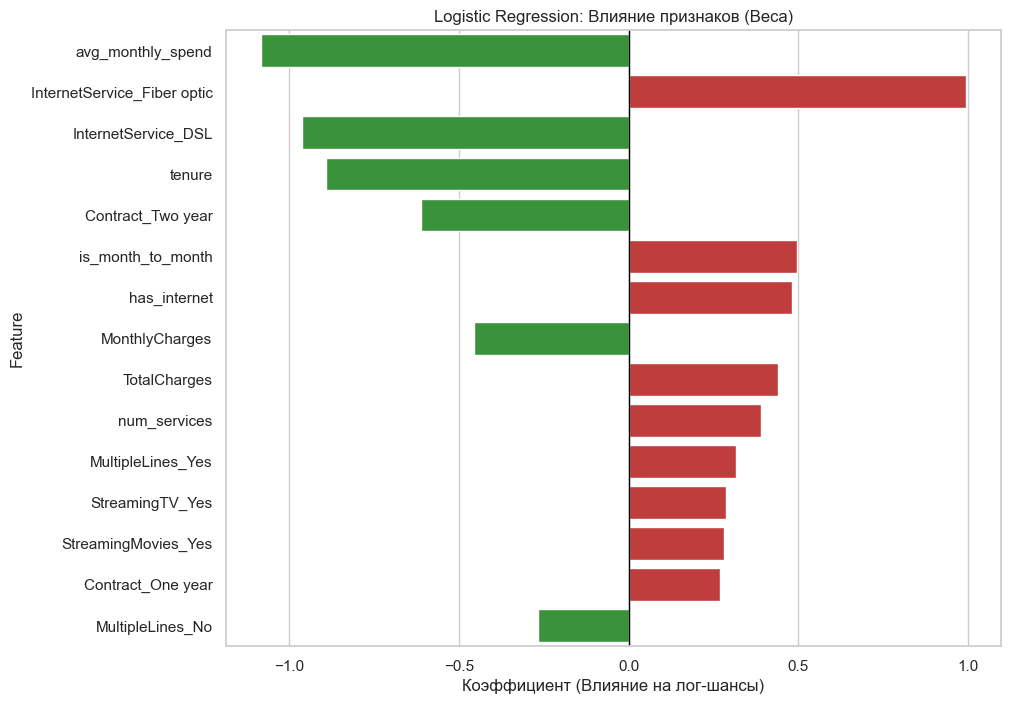

In [14]:
# --- Logistic Regression ---
# 1. Получаем модель и имена
lr_model_step = lr_model.named_steps['model']
feature_names_lr = get_feature_names(lr_model)

# 2. Создаем DataFrame с коэффициентами
importances_lr = pd.DataFrame({
    'Feature': feature_names_lr,
    'Coefficient': lr_model_step.coef_[0] # Берем [0], т.к. массив двумерный
})

# 3. Считаем абсолютное значение для сортировки, но сохраняем знак для цвета
importances_lr['Abs_Coeff'] = importances_lr['Coefficient'].abs()
importances_lr = importances_lr.sort_values(by='Abs_Coeff', ascending=False).head(15)

# 4. Рисуем
plt.figure(figsize=(10, 8))
# Красный = Повышает отток, Зеленый = Понижает отток (удерживает)
colors = ['#d62728' if x > 0 else '#2ca02c' for x in importances_lr['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=importances_lr, palette=colors)
plt.title('Logistic Regression: Влияние признаков (Веса)')
plt.xlabel('Коэффициент (Влияние на лог-шансы)')
plt.axvline(0, color='black', linewidth=1) # Линия на нуле
plt.show()

C:\Users\nurs\AppData\Local\Temp\ipykernel_2444\4279778860.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances_dt, palette='Blues_r')


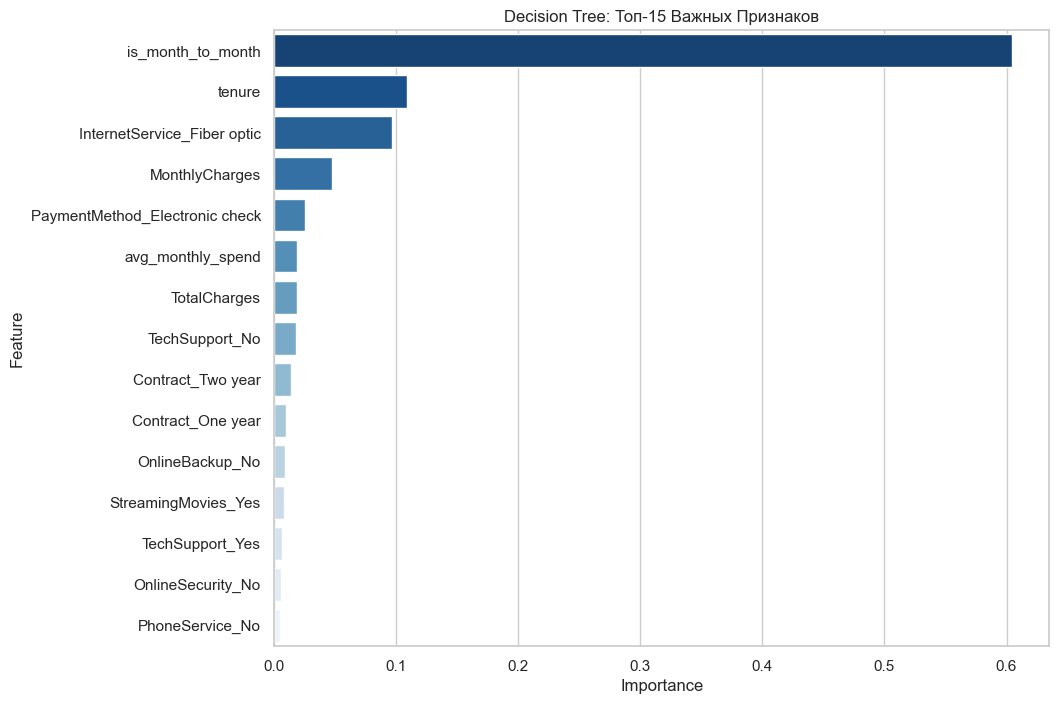

In [15]:
# --- Decision Tree ---
# 1. Получаем модель и имена
dt_model_step = dt_model.named_steps['model']
feature_names_dt = get_feature_names(dt_model)

# 2. Создаем DataFrame
importances_dt = pd.DataFrame({
    'Feature': feature_names_dt,
    'Importance': dt_model_step.feature_importances_
})

# 3. Сортируем
importances_dt = importances_dt.sort_values(by='Importance', ascending=False).head(15)

# 4. Рисуем
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_dt, palette='Blues_r')
plt.title('Decision Tree: Топ-15 Важных Признаков')
plt.show()